# Build a TextCNN  model

In this notebook, we are going to build a Convolutional Neural Network model according to the following paper: https://arxiv.org/pdf/1408.5882.pdf. The model will be trained on the top of the pre-trained Glove embeddings.

### Building and training the model

Let's start with importing all indispensable libraries.

In [1]:
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Now, we are going to load the tarining and validation sets, but we will use only the clean_review column and label column.

In [2]:
# Import the dataset. Use clean_review and label columns
train_dataset = pd.read_csv('drugreview/drugreview_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'rating'])

# Change columns order
train_dataset['label'] = train_dataset.rating >= 5
train_dataset = train_dataset[['clean_review', 'label']]

In [3]:
# Depict the first 5 rows of the training set
train_dataset = train_dataset.dropna()
train_dataset.head()

,clean_review,label
1,okay anxiety gotten worse past couple years po...,True
6,reading possible effects scary medicine gave l...,True
9,clonazepam effective controlling agitation pro...,True
11,experienced effects considering anorexia nervo...,True
12,i&#039;ve gianvi months skin clear didn&#039;t...,True


In [4]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('dataset/drugreview_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
val_dataset['label'] = val_dataset.rating >= 5
val_dataset = val_dataset[['clean_review', 'label']]

In [5]:
# Depict the first 5 rows of the validation set
val_dataset = val_dataset.dropna()
val_dataset.head()

,clean_review,label
0,year old son took night went deep sea fishing ...,True
1,daughter epiduo grade junior year work wonders...,True
2,i&#039;ve implant months day got totally felt ...,True
3,wanted wait days post couldn&#039;t results am...,True
4,colonoscopy best prep far morning took prep pm...,True


Below we will use the BatchIterator class defined in the *vocabulary* notebook to create the vocabulary, trim sequences in terms of the rare word occurrence and the length, map words to their numerical representation (word2index), furthermore BatchIterator sorts dataset examples, generates batches, performs sequence padding and enables to use it instance to iterate through all batches.

To create the weights matrix we have to set use_pretrained_vectors=True and supply the weight file path, Glove vectors file name and the directory and the name of the file to which we will export the prepared weights matrix. To use different word embeddings, simply pass on their file to the BatchIterator class.

In [6]:


train_iterator = BatchIterator(train_dataset, batch_size=128, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.7,
                               use_pretrained_vectors=True, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights_train.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
14773/39267 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 48
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 12312/14777 of pre-trained word vectors.
2465 vectors initialized to random numbers
Weights vectors saved into glove/weights_train.npy
Batches created


In [7]:
val_iterator = BatchIterator(val_dataset, batch_size=128, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.7, use_pretrained_vectors=False, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights_val.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
4655/11853 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 46
Mapped words to indices
Batches created


We have to check out how batches that we created look like before we pass them into the model. For the record, the set of batches for input and output variables is returned as a dictionary, thus we will just look at the dictionary keys to find out how to extract particular variables.

In [8]:
for batches in train_iterator:
    print(batches.keys())
    break

dict_keys(['input_seq', 'target', 'x_lengths'])


Notice that the output batch has the dimensions: (batch_size, seq_len)

In [9]:
for batches in train_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([128, 49])
target shape:  torch.Size([128])
x_lengths shape:  torch.Size([128])


In [10]:
for batches in val_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([128, 7])
target shape:  torch.Size([128])
x_lengths shape:  torch.Size([128])


Next step is to build the TextCNN model.

In [11]:
class TextCNN(nn.Module):
    """Text Convolutional Neural Network.
        
    Parameters
    ----------
    conv_config: dict
        Dictionary of convolution layer settings (keys: 'num_channels', 'kernel_sizes')
        Number of channels corresponds to the number of filters.
    weight_matrix: numpy.ndarray
        Matrix of pre-trained word embeddings.
    output_size: int
        Number of classes.
    dropout: float, optional (default=0.5)
        Probability of an element of the tensor to be zeroed.

    """
    
    def __init__(self, conv_config, weights_matrix, output_size, dropout=0.5):
        
        # Inherit everything from the nn.Module
        super(TextCNN, self).__init__()
        
        # Initialize attributes
        self.conv_config = conv_config
        self.output_size = output_size
        self.weights_matrix = weights_matrix
        self.dropout_p = dropout
        self.vocab_size, self.embedding_dim = self.weights_matrix.shape
        
        # Initialize layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        # Load the weights to the embedding layer
        self.embedding.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
        self.embedding.weight.requires_grad = False          
            
        self.convolutions = nn.ModuleList([nn.Sequential(
            nn.Conv1d(self.embedding_dim, self.conv_config['num_channels'], kernel_size=kernel),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d((1,)))\
                         for kernel in self.conv_config['kernel_sizes']])    
            
        self.dropout = nn.Dropout(self.dropout_p)    
        self.linear = nn.Linear(self.conv_config['num_channels'] * len(self.conv_config['kernel_sizes']),\
                                                                       self.output_size)

        
    def forward(self, input_seq):
        """Forward propagate through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.
        
        """        
        # Embeddings shapes
        # Input: (batch_size,  seq_length)
        # Output: (batch_size, embedding_dim, seq_length)
        emb_out = self.embedding(input_seq).permute(0,2,1)

        # Conv1d -> Relu -> AdaptiveMaxPool1d
        # Input: (batch_size, embedding_dim, seq_length)
        # Output: (batch_size, num_channels)
            
        conv_out = [conv(emb_out).squeeze(2) for conv in self.convolutions]       

        # Concatenate the list of convolving outputs from the previous step
        concat_out = torch.cat(conv_out, dim=1)

        concat_out = self.dropout(concat_out)
        out = self.linear(concat_out)
        return F.log_softmax(out, dim=-1)
    
    
    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.
        
        """
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):
        """Add optimizer to the model.
        
        """
        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
        """Specify the device.
        
        """
        self.device = device
    
    
    def train_model(self, train_iterator):
        """Perform single training epoch.
        
        Parameters
        ----------
        train_iterator: BatchIterator
            BatchIterator class object containing training batches.
            
        Returns
        -------
        train_losses: list
            List of the training average batch losses.
        avg_loss: float
            Average loss on the entire training set.
        accuracy: float
            Models accuracy on the entire training set.
            
        """
        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):
        """Perform the one evaluation epoch.
        
        Parameters
        ----------
        eval_iterator: BatchIterator
            BatchIterator class object containing evaluation batches.
        conf_mtx: boolean, optional (default=False)
            Whether to print the confusion matrix at each epoch.
            
        Returns
        -------
        eval_losses: list
            List of the evaluation average batch losses.
        avg_loss: float
            Average loss on the entire evaluation set.
        accuracy: float
            Models accuracy on the entire evaluation set.
        conf_matrix: list
            Confusion matrix.
            
        """
        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
        
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix


Now we will instantiate the model, add loss function, optimizer, and device to it and begin the training.

In [12]:
# Initialize parameters
conv_config = {'num_channels': 50, 'kernel_sizes': [1,2]}
output_size = 2
learning_rate = 0.001
epochs = 50
dropout = 0.8

# Load the weights matrix
weights = np.load('glove/weights_train.npy')

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = TextCNN(conv_config, weights, output_size, dropout)

# Move the model to GPU if possible
if CUDA:
    model.cuda()

model.add_loss_fn(nn.NLLLoss())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=3)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []

for epoch in range(epochs):
    
    print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))
    
    train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)
    
    train_losses_list.append(train_losses)
    train_avg_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_accuracy)
    
    _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)
    
    eval_avg_loss_list.append(eval_avg_loss)
    eval_accuracy_list.append(eval_accuracy)
    conf_matrix_list.append(conf_matrix)
    
    print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
          .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))
    
    if early_stop.stop(eval_avg_loss, model, delta=0.003):
        break

    


Start epoch [1/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.6029. Accuracy: 0.724
Iteration: 200. Average training loss: 0.5578. Accuracy: 0.736
Iteration: 300. Average training loss: 0.5377. Accuracy: 0.742


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [1/50]: Train accuracy: 0.744. Train loss: 0.5611. Evaluation accuracy: 0.759. Evaluation loss: 0.5010

Start epoch [2/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.5243. Accuracy: 0.756
Iteration: 200. Average training loss: 0.5126. Accuracy: 0.759
Iteration: 300. Average training loss: 0.5097. Accuracy: 0.759


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [2/50]: Train accuracy: 0.759. Train loss: 0.5151. Evaluation accuracy: 0.773. Evaluation loss: 0.4744

Start epoch [3/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.5032. Accuracy: 0.764
Iteration: 200. Average training loss: 0.4994. Accuracy: 0.764
Iteration: 300. Average training loss: 0.4950. Accuracy: 0.765


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [3/50]: Train accuracy: 0.765. Train loss: 0.4999. Evaluation accuracy: 0.780. Evaluation loss: 0.4622

Start epoch [4/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4941. Accuracy: 0.766
Iteration: 200. Average training loss: 0.4878. Accuracy: 0.769
Iteration: 300. Average training loss: 0.4885. Accuracy: 0.770


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [4/50]: Train accuracy: 0.769. Train loss: 0.4908. Evaluation accuracy: 0.788. Evaluation loss: 0.4518

Start epoch [5/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4857. Accuracy: 0.773
Iteration: 200. Average training loss: 0.4822. Accuracy: 0.772
Iteration: 300. Average training loss: 0.4821. Accuracy: 0.772


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [5/50]: Train accuracy: 0.771. Train loss: 0.4842. Evaluation accuracy: 0.791. Evaluation loss: 0.4465

Start epoch [6/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4816. Accuracy: 0.774
Iteration: 200. Average training loss: 0.4778. Accuracy: 0.774
Iteration: 300. Average training loss: 0.4792. Accuracy: 0.775


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [6/50]: Train accuracy: 0.775. Train loss: 0.4795. Evaluation accuracy: 0.798. Evaluation loss: 0.4399

Start epoch [7/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4761. Accuracy: 0.778
Iteration: 200. Average training loss: 0.4747. Accuracy: 0.778
Iteration: 300. Average training loss: 0.4718. Accuracy: 0.778


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [7/50]: Train accuracy: 0.777. Train loss: 0.4748. Evaluation accuracy: 0.800. Evaluation loss: 0.4351

Start epoch [8/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4709. Accuracy: 0.782
Iteration: 200. Average training loss: 0.4690. Accuracy: 0.782
Iteration: 300. Average training loss: 0.4699. Accuracy: 0.780


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [8/50]: Train accuracy: 0.779. Train loss: 0.4712. Evaluation accuracy: 0.797. Evaluation loss: 0.4338

Start epoch [9/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4676. Accuracy: 0.781
Iteration: 200. Average training loss: 0.4701. Accuracy: 0.779
Iteration: 300. Average training loss: 0.4695. Accuracy: 0.780


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [9/50]: Train accuracy: 0.780. Train loss: 0.4687. Evaluation accuracy: 0.802. Evaluation loss: 0.4281

Start epoch [10/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4623. Accuracy: 0.785
Iteration: 200. Average training loss: 0.4673. Accuracy: 0.783
Iteration: 300. Average training loss: 0.4585. Accuracy: 0.784


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [10/50]: Train accuracy: 0.783. Train loss: 0.4631. Evaluation accuracy: 0.803. Evaluation loss: 0.4255

Start epoch [11/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4664. Accuracy: 0.784
Iteration: 200. Average training loss: 0.4609. Accuracy: 0.783
Iteration: 300. Average training loss: 0.4631. Accuracy: 0.782


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [11/50]: Train accuracy: 0.782. Train loss: 0.4646. Evaluation accuracy: 0.806. Evaluation loss: 0.4238

Start epoch [12/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4588. Accuracy: 0.785
Iteration: 200. Average training loss: 0.4604. Accuracy: 0.787
Iteration: 300. Average training loss: 0.4622. Accuracy: 0.786


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [12/50]: Train accuracy: 0.785. Train loss: 0.4612. Evaluation accuracy: 0.810. Evaluation loss: 0.4227

Start epoch [13/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4608. Accuracy: 0.785
Iteration: 200. Average training loss: 0.4592. Accuracy: 0.783
Iteration: 300. Average training loss: 0.4579. Accuracy: 0.785


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [13/50]: Train accuracy: 0.784. Train loss: 0.4602. Evaluation accuracy: 0.803. Evaluation loss: 0.4203

Start epoch [14/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4575. Accuracy: 0.786
Iteration: 200. Average training loss: 0.4588. Accuracy: 0.786
Iteration: 300. Average training loss: 0.4564. Accuracy: 0.787


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [14/50]: Train accuracy: 0.786. Train loss: 0.4583. Evaluation accuracy: 0.810. Evaluation loss: 0.4207

Start epoch [15/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4571. Accuracy: 0.787
Iteration: 200. Average training loss: 0.4596. Accuracy: 0.787
Iteration: 300. Average training loss: 0.4573. Accuracy: 0.787


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [15/50]: Train accuracy: 0.786. Train loss: 0.4583. Evaluation accuracy: 0.807. Evaluation loss: 0.4168

Start epoch [16/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4528. Accuracy: 0.788
Iteration: 200. Average training loss: 0.4570. Accuracy: 0.788
Iteration: 300. Average training loss: 0.4539. Accuracy: 0.789


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [16/50]: Train accuracy: 0.787. Train loss: 0.4563. Evaluation accuracy: 0.811. Evaluation loss: 0.4169

Start epoch [17/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4554. Accuracy: 0.787
Iteration: 200. Average training loss: 0.4569. Accuracy: 0.786
Iteration: 300. Average training loss: 0.4514. Accuracy: 0.786


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [17/50]: Train accuracy: 0.787. Train loss: 0.4548. Evaluation accuracy: 0.807. Evaluation loss: 0.4155

Start epoch [18/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4519. Accuracy: 0.789
Iteration: 200. Average training loss: 0.4539. Accuracy: 0.788
Iteration: 300. Average training loss: 0.4586. Accuracy: 0.787


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [18/50]: Train accuracy: 0.787. Train loss: 0.4546. Evaluation accuracy: 0.812. Evaluation loss: 0.4130

Start epoch [19/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4484. Accuracy: 0.793
Iteration: 200. Average training loss: 0.4526. Accuracy: 0.791
Iteration: 300. Average training loss: 0.4534. Accuracy: 0.791


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [19/50]: Train accuracy: 0.790. Train loss: 0.4522. Evaluation accuracy: 0.813. Evaluation loss: 0.4143

Start epoch [20/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4476. Accuracy: 0.791
Iteration: 200. Average training loss: 0.4504. Accuracy: 0.789
Iteration: 300. Average training loss: 0.4570. Accuracy: 0.787


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [20/50]: Train accuracy: 0.787. Train loss: 0.4533. Evaluation accuracy: 0.813. Evaluation loss: 0.4136

Start epoch [21/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4448. Accuracy: 0.789
Iteration: 200. Average training loss: 0.4468. Accuracy: 0.791
Iteration: 300. Average training loss: 0.4483. Accuracy: 0.791


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [21/50]: Train accuracy: 0.790. Train loss: 0.4480. Evaluation accuracy: 0.814. Evaluation loss: 0.4101

Start epoch [22/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4483. Accuracy: 0.792
Iteration: 200. Average training loss: 0.4504. Accuracy: 0.792
Iteration: 300. Average training loss: 0.4499. Accuracy: 0.791


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [22/50]: Train accuracy: 0.790. Train loss: 0.4499. Evaluation accuracy: 0.816. Evaluation loss: 0.4110

Start epoch [23/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4416. Accuracy: 0.798
Iteration: 200. Average training loss: 0.4509. Accuracy: 0.795
Iteration: 300. Average training loss: 0.4532. Accuracy: 0.793


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [23/50]: Train accuracy: 0.793. Train loss: 0.4495. Evaluation accuracy: 0.813. Evaluation loss: 0.4102

Start epoch [24/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4495. Accuracy: 0.789
Iteration: 200. Average training loss: 0.4490. Accuracy: 0.790
Iteration: 300. Average training loss: 0.4466. Accuracy: 0.792


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [24/50]: Train accuracy: 0.790. Train loss: 0.4500. Evaluation accuracy: 0.815. Evaluation loss: 0.4102

Start epoch [25/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4437. Accuracy: 0.797
Iteration: 200. Average training loss: 0.4463. Accuracy: 0.795
Iteration: 300. Average training loss: 0.4426. Accuracy: 0.794


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [25/50]: Train accuracy: 0.793. Train loss: 0.4464. Evaluation accuracy: 0.818. Evaluation loss: 0.4093

Start epoch [26/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4448. Accuracy: 0.794
Iteration: 200. Average training loss: 0.4453. Accuracy: 0.792
Iteration: 300. Average training loss: 0.4450. Accuracy: 0.791


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [26/50]: Train accuracy: 0.791. Train loss: 0.4447. Evaluation accuracy: 0.819. Evaluation loss: 0.4037

Start epoch [27/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4411. Accuracy: 0.798
Iteration: 200. Average training loss: 0.4459. Accuracy: 0.794
Iteration: 300. Average training loss: 0.4453. Accuracy: 0.793


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [27/50]: Train accuracy: 0.792. Train loss: 0.4456. Evaluation accuracy: 0.816. Evaluation loss: 0.4052

Start epoch [28/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4412. Accuracy: 0.796
Iteration: 200. Average training loss: 0.4473. Accuracy: 0.795
Iteration: 300. Average training loss: 0.4433. Accuracy: 0.795


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [28/50]: Train accuracy: 0.794. Train loss: 0.4452. Evaluation accuracy: 0.817. Evaluation loss: 0.4061

Start epoch [29/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4443. Accuracy: 0.794
Iteration: 200. Average training loss: 0.4489. Accuracy: 0.792
Iteration: 300. Average training loss: 0.4430. Accuracy: 0.793


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [29/50]: Train accuracy: 0.792. Train loss: 0.4453. Evaluation accuracy: 0.821. Evaluation loss: 0.4026

Start epoch [30/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4429. Accuracy: 0.794
Iteration: 200. Average training loss: 0.4486. Accuracy: 0.793
Iteration: 300. Average training loss: 0.4451. Accuracy: 0.793


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [30/50]: Train accuracy: 0.792. Train loss: 0.4460. Evaluation accuracy: 0.817. Evaluation loss: 0.4037

Start epoch [31/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4405. Accuracy: 0.798
Iteration: 200. Average training loss: 0.4404. Accuracy: 0.797
Iteration: 300. Average training loss: 0.4444. Accuracy: 0.796


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [31/50]: Train accuracy: 0.796. Train loss: 0.4418. Evaluation accuracy: 0.821. Evaluation loss: 0.4003

Start epoch [32/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4395. Accuracy: 0.796
Iteration: 200. Average training loss: 0.4418. Accuracy: 0.796
Iteration: 300. Average training loss: 0.4449. Accuracy: 0.796


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [32/50]: Train accuracy: 0.794. Train loss: 0.4431. Evaluation accuracy: 0.819. Evaluation loss: 0.4015

Start epoch [33/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4394. Accuracy: 0.794
Iteration: 200. Average training loss: 0.4431. Accuracy: 0.792
Iteration: 300. Average training loss: 0.4413. Accuracy: 0.792


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [33/50]: Train accuracy: 0.793. Train loss: 0.4416. Evaluation accuracy: 0.821. Evaluation loss: 0.3994

Start epoch [34/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4414. Accuracy: 0.795
Iteration: 200. Average training loss: 0.4433. Accuracy: 0.795
Iteration: 300. Average training loss: 0.4416. Accuracy: 0.794


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [34/50]: Train accuracy: 0.793. Train loss: 0.4427. Evaluation accuracy: 0.818. Evaluation loss: 0.4010

Start epoch [35/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4406. Accuracy: 0.798
Iteration: 200. Average training loss: 0.4413. Accuracy: 0.796
Iteration: 300. Average training loss: 0.4409. Accuracy: 0.796


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [35/50]: Train accuracy: 0.795. Train loss: 0.4405. Evaluation accuracy: 0.824. Evaluation loss: 0.3967

Start epoch [36/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4368. Accuracy: 0.800
Iteration: 200. Average training loss: 0.4389. Accuracy: 0.800
Iteration: 300. Average training loss: 0.4363. Accuracy: 0.798


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [36/50]: Train accuracy: 0.798. Train loss: 0.4381. Evaluation accuracy: 0.821. Evaluation loss: 0.3990

Start epoch [37/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4375. Accuracy: 0.797
Iteration: 200. Average training loss: 0.4427. Accuracy: 0.795
Iteration: 300. Average training loss: 0.4381. Accuracy: 0.795


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [37/50]: Train accuracy: 0.795. Train loss: 0.4401. Evaluation accuracy: 0.820. Evaluation loss: 0.3997

Start epoch [38/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4349. Accuracy: 0.800
Iteration: 200. Average training loss: 0.4354. Accuracy: 0.799
Iteration: 300. Average training loss: 0.4364. Accuracy: 0.798


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [38/50]: Train accuracy: 0.798. Train loss: 0.4359. Evaluation accuracy: 0.819. Evaluation loss: 0.3974

Start epoch [39/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4411. Accuracy: 0.796
Iteration: 200. Average training loss: 0.4376. Accuracy: 0.796
Iteration: 300. Average training loss: 0.4388. Accuracy: 0.796


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [39/50]: Train accuracy: 0.797. Train loss: 0.4392. Evaluation accuracy: 0.822. Evaluation loss: 0.3972

Start epoch [40/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4334. Accuracy: 0.797
Iteration: 200. Average training loss: 0.4426. Accuracy: 0.796
Iteration: 300. Average training loss: 0.4376. Accuracy: 0.795


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [40/50]: Train accuracy: 0.794. Train loss: 0.4393. Evaluation accuracy: 0.821. Evaluation loss: 0.3986

Start epoch [41/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4386. Accuracy: 0.799
Iteration: 200. Average training loss: 0.4359. Accuracy: 0.799
Iteration: 300. Average training loss: 0.4436. Accuracy: 0.797


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [41/50]: Train accuracy: 0.796. Train loss: 0.4401. Evaluation accuracy: 0.818. Evaluation loss: 0.3988

Start epoch [42/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4326. Accuracy: 0.799
Iteration: 200. Average training loss: 0.4368. Accuracy: 0.798
Iteration: 300. Average training loss: 0.4366. Accuracy: 0.798


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [42/50]: Train accuracy: 0.798. Train loss: 0.4357. Evaluation accuracy: 0.825. Evaluation loss: 0.3957

Start epoch [43/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4324. Accuracy: 0.800
Iteration: 200. Average training loss: 0.4350. Accuracy: 0.798
Iteration: 300. Average training loss: 0.4375. Accuracy: 0.797


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [43/50]: Train accuracy: 0.797. Train loss: 0.4357. Evaluation accuracy: 0.827. Evaluation loss: 0.3944

Start epoch [44/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4365. Accuracy: 0.800
Iteration: 200. Average training loss: 0.4424. Accuracy: 0.796
Iteration: 300. Average training loss: 0.4311. Accuracy: 0.798


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [44/50]: Train accuracy: 0.797. Train loss: 0.4375. Evaluation accuracy: 0.819. Evaluation loss: 0.3952

Start epoch [45/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4364. Accuracy: 0.796
Iteration: 200. Average training loss: 0.4357. Accuracy: 0.797
Iteration: 300. Average training loss: 0.4367. Accuracy: 0.797


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [45/50]: Train accuracy: 0.797. Train loss: 0.4371. Evaluation accuracy: 0.820. Evaluation loss: 0.3948

Start epoch [46/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4345. Accuracy: 0.798
Iteration: 200. Average training loss: 0.4360. Accuracy: 0.798
Iteration: 300. Average training loss: 0.4299. Accuracy: 0.800


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [46/50]: Train accuracy: 0.798. Train loss: 0.4342. Evaluation accuracy: 0.815. Evaluation loss: 0.3972

Start epoch [47/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4315. Accuracy: 0.802
Iteration: 200. Average training loss: 0.4357. Accuracy: 0.801
Iteration: 300. Average training loss: 0.4389. Accuracy: 0.798


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [47/50]: Train accuracy: 0.799. Train loss: 0.4352. Evaluation accuracy: 0.824. Evaluation loss: 0.3936

Start epoch [48/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4295. Accuracy: 0.799
Iteration: 200. Average training loss: 0.4357. Accuracy: 0.799
Iteration: 300. Average training loss: 0.4357. Accuracy: 0.800


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [48/50]: Train accuracy: 0.798. Train loss: 0.4346. Evaluation accuracy: 0.824. Evaluation loss: 0.3944

Start epoch [49/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4291. Accuracy: 0.799
Iteration: 200. Average training loss: 0.4328. Accuracy: 0.799
Iteration: 300. Average training loss: 0.4339. Accuracy: 0.798


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [49/50]: Train accuracy: 0.797. Train loss: 0.4337. Evaluation accuracy: 0.818. Evaluation loss: 0.3933

Start epoch [50/50]


Training:   0%|          | 0/354 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.4322. Accuracy: 0.798
Iteration: 200. Average training loss: 0.4338. Accuracy: 0.797
Iteration: 300. Average training loss: 0.4371. Accuracy: 0.797


Evaluation:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch [50/50]: Train accuracy: 0.796. Train loss: 0.4347. Evaluation accuracy: 0.820. Evaluation loss: 0.3948


In [13]:
# Add the dataset initial loss
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])

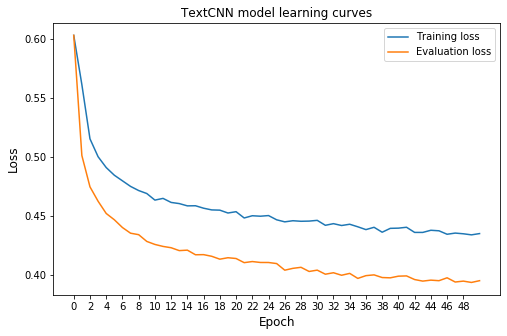

In [14]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('TextCNN model learning curves')
plt.xticks(ticks=range(0,49,2))
plt.legend()
plt.show()

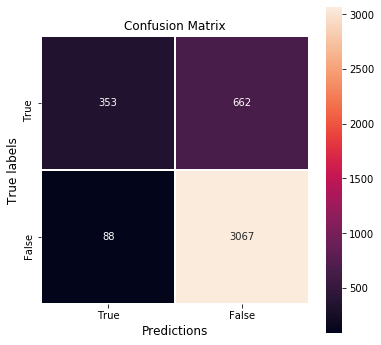

In [22]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

The model achieved the validation accuracy of 0.847, while the training accuracy was 0.833. The model's best state was saved to the *checkpoint.pt* file in the current directory.

### The generalization error

In [16]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('drugreview/drugreview_feat_clean/test_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
test_dataset['label'] = test_dataset.rating >= 5
test_dataset = test_dataset[['clean_review', 'label']]

In [17]:
test_dataset = test_dataset.dropna()
test_dataset.head()

,clean_review,label
0,i&#039;ve tried antidepressants years citalopr...,True
1,son crohn&#039;s disease asacol complaints sho...,True
2,quick reduction symptoms,True
3,contrave combines drugs alcohol smoking opioid...,True
4,birth control cycle reading reviews type simil...,True


In [18]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=True, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights_train.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
15210/40911 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 59
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 13837/17082 of pre-trained word vectors.
3245 vectors initialized to random numbers
Weights vectors saved into glove/weights_train.npy
Batches created


In [19]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

Evaluation:   0%|          | 0/189 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.4046. Accuracy: 0.81


In [20]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.809. Test error: 0.406


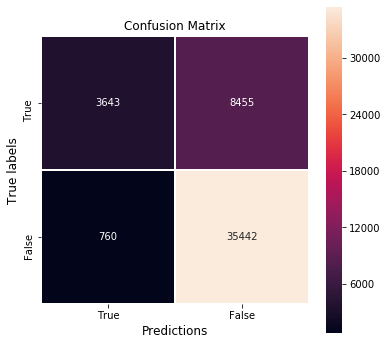

In [21]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

The generalization accuracy of the TextCNN model is 0.81. As we can see in the above plot of the confusion matrix the number of False negative predictions (760) is greater than the amount of False positive predictions (8455) which is good.